# Projeção de ocupação de leitos enfermaria e UTI em estados com modelo SEIR

Utilizamos o modelo epidemiológico SEIR (Suscetíveis, Expostos, Infectados e
Removidos) adaptado segundo o modelo desenvolvido por Hill (2020) para
calcular a disseminação e evolução clínica do COVID-19. De acordo com esse
modelo, uma população é dividida em diferentes estados populacionais, grupos
mutuamente excludentes de indivíduos:
- Suscetíveis ($S$): aqueles que não têm imunidade à doença, estes se tornam
expostos à doença a uma taxa $\\beta_i$ devido ao contato com indivíduos
infetados $I_i$;
- Expostos ($E$): aqueles que entram em contato com a doença e desenvolvem
ou não sintomas, mas ainda não transmitem infecção. Esses indivíduos
expostos progridem para o primeiro estágio de infecção ($I_1$), leve, a
uma taxa $\sigma$.
- Infectados ($I$): são aqueles que desenvolvem sintomas e transmitem a
doença a uma taxa $\\beta_i$. Os casos de infecção são separados em
diferentes estágios de gravidade:
- Leve ($I_1$): aquele que não necessita de hospitalização, progride para
    o estado severo a uma taxa $p_1$, ou se recupera a uma taxa $\gamma_1$;
- Severo ($I_2$): aquele que necessita de hospitalização, progride para o
    estado crítico a uma taxa $p_1$, ou se recupera a uma taxa $\gamma_2$;
- Grave ($I_3$): aquele que além de hospitalização, necessita de
    tratamento intensivo com equipamento de ventiladores. Chegando ao caso
    grave, o indivíduo pode se recuperar a uma taxa $\gamma_3$ ou o quadro
    pode levar à morte com uma taxa $\mu$;
- Recuperados ($R$): aqueles que, após o curso da doença, se recuperam e
desenvolvem imunidade - não retornam ao estado suscetível.
- Mortos ($D$): indivíduos que morrem pelo agravamento da infecção.

Conforme a descrição acima, o conjunto de equações que determina a dinâmica do modelo é dado por:

$\frac{dS}{dt} = - (β_1 I_1 + β_2 I_2 + β_3 I_3) S$

$\frac{dE}{dt} = (β_1 I_1 + β_2 I_2 + β_3 I_3) S - \sigma E$

$\frac{dI_1}{dt} = \sigma E - (γ_1 + p_1) I_1$

$\frac{dI_2}{dt} = p_1 I_1 - (γ_2 + p_2) I_2$

$\frac{dI_3}{dt} = p_2 I_2 - (γ_3 + μ) I_3$

$\frac{dR}{dt} = γ_1 I_1 + γ_2 I_2 + γ_3 I_3$

$\frac{dD}{dt} = μ I_3$


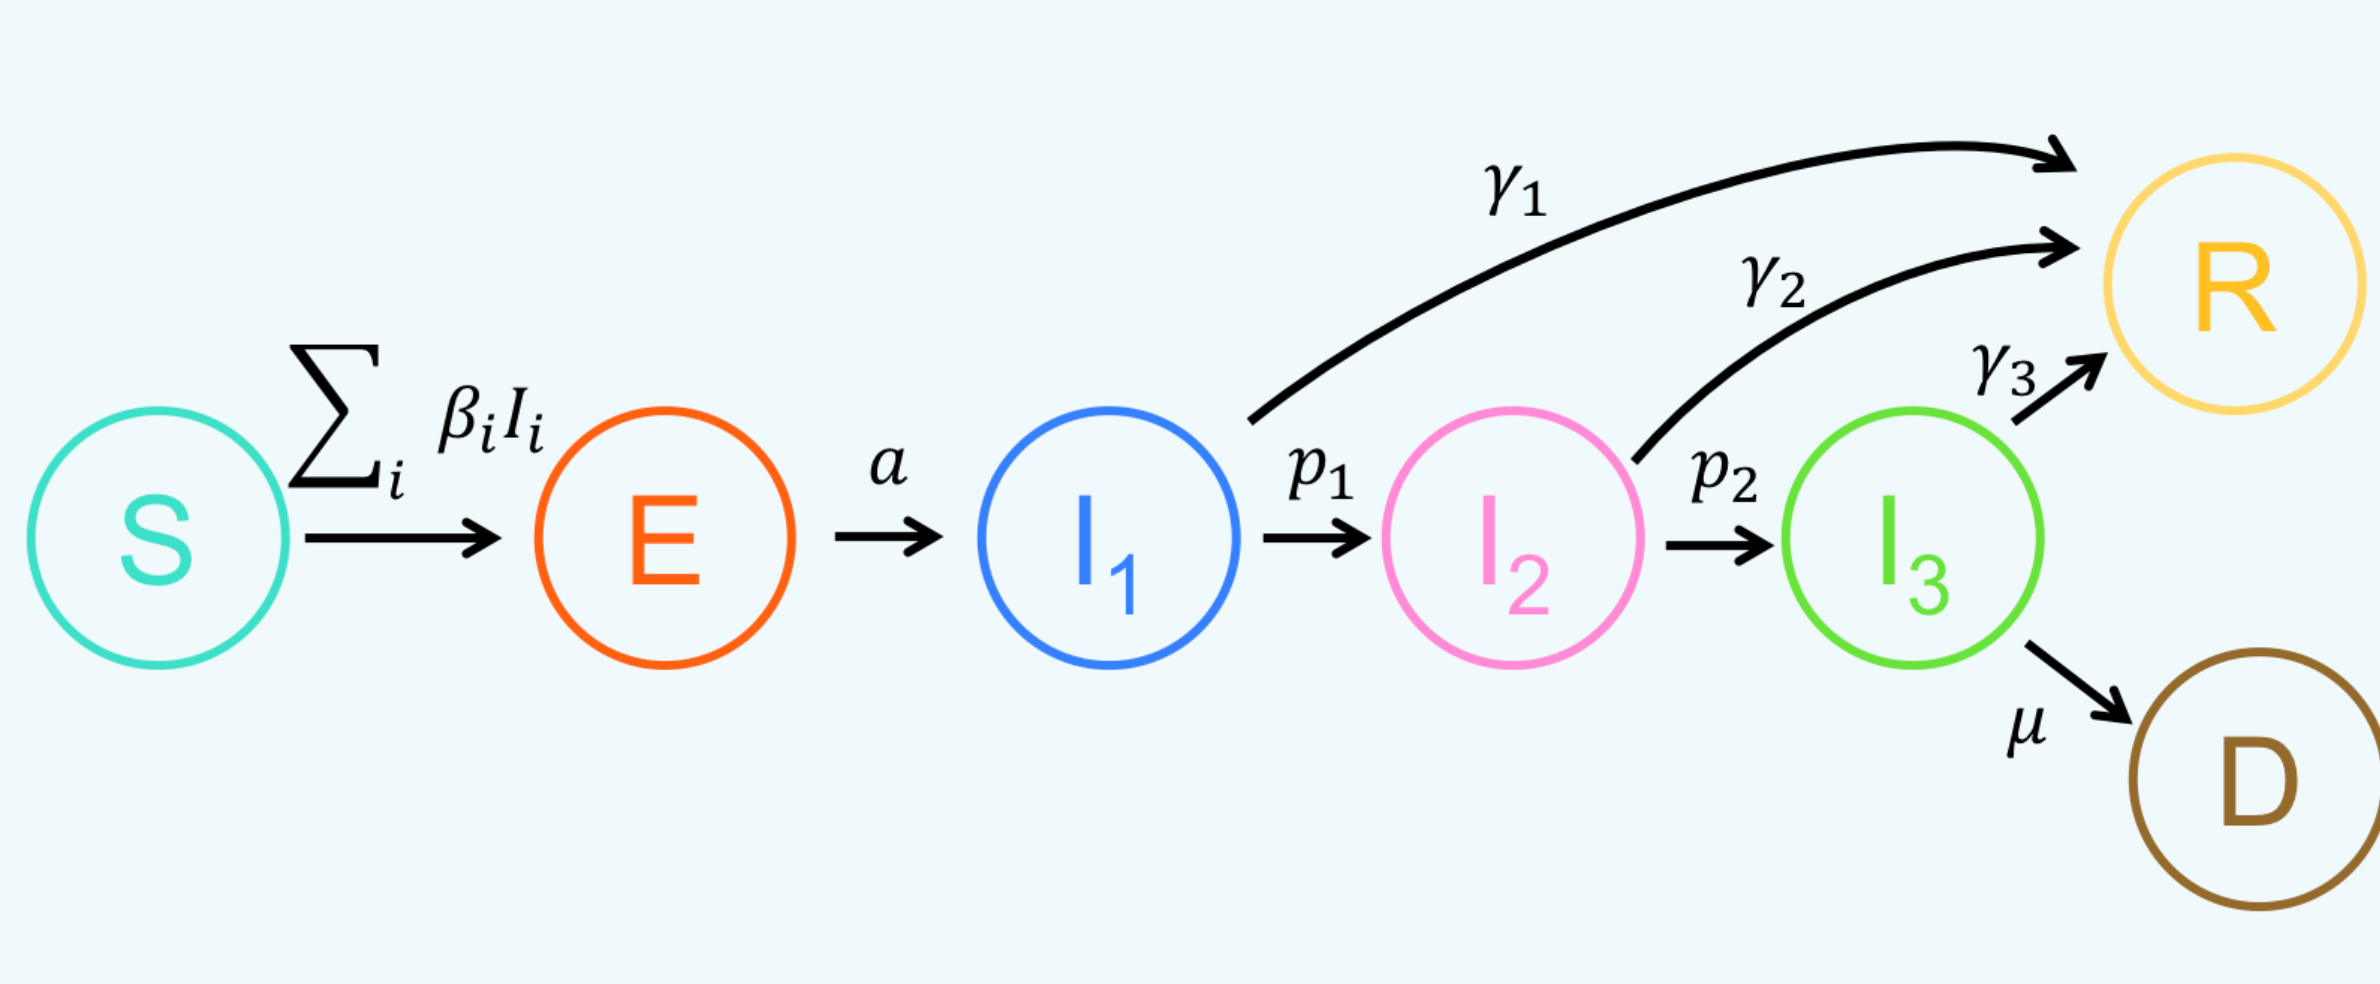

In [42]:
from IPython.display import Image
Image("images/seir_flow.png")

## Importa bibliotecas

In [9]:
import pandas as pd
import yaml
import requests

from code import prepare, seir, simulator

## Como rodar a simulação para os estados

### Carrega parâmetros fixos do arquivo de configuração

Utilizamos parâmetros fixos da literatura de **tempos de progressão da doença** para os cálculos do simulador. 

Os percentuais de tipos de hospitalizações e mortalidade não são mais utilizados diretamente no modelo, mas sim no cálculo da tabela desses percentuais por nível geográfico (neste caso estado) que ponderamos pela distribuição etária da população.

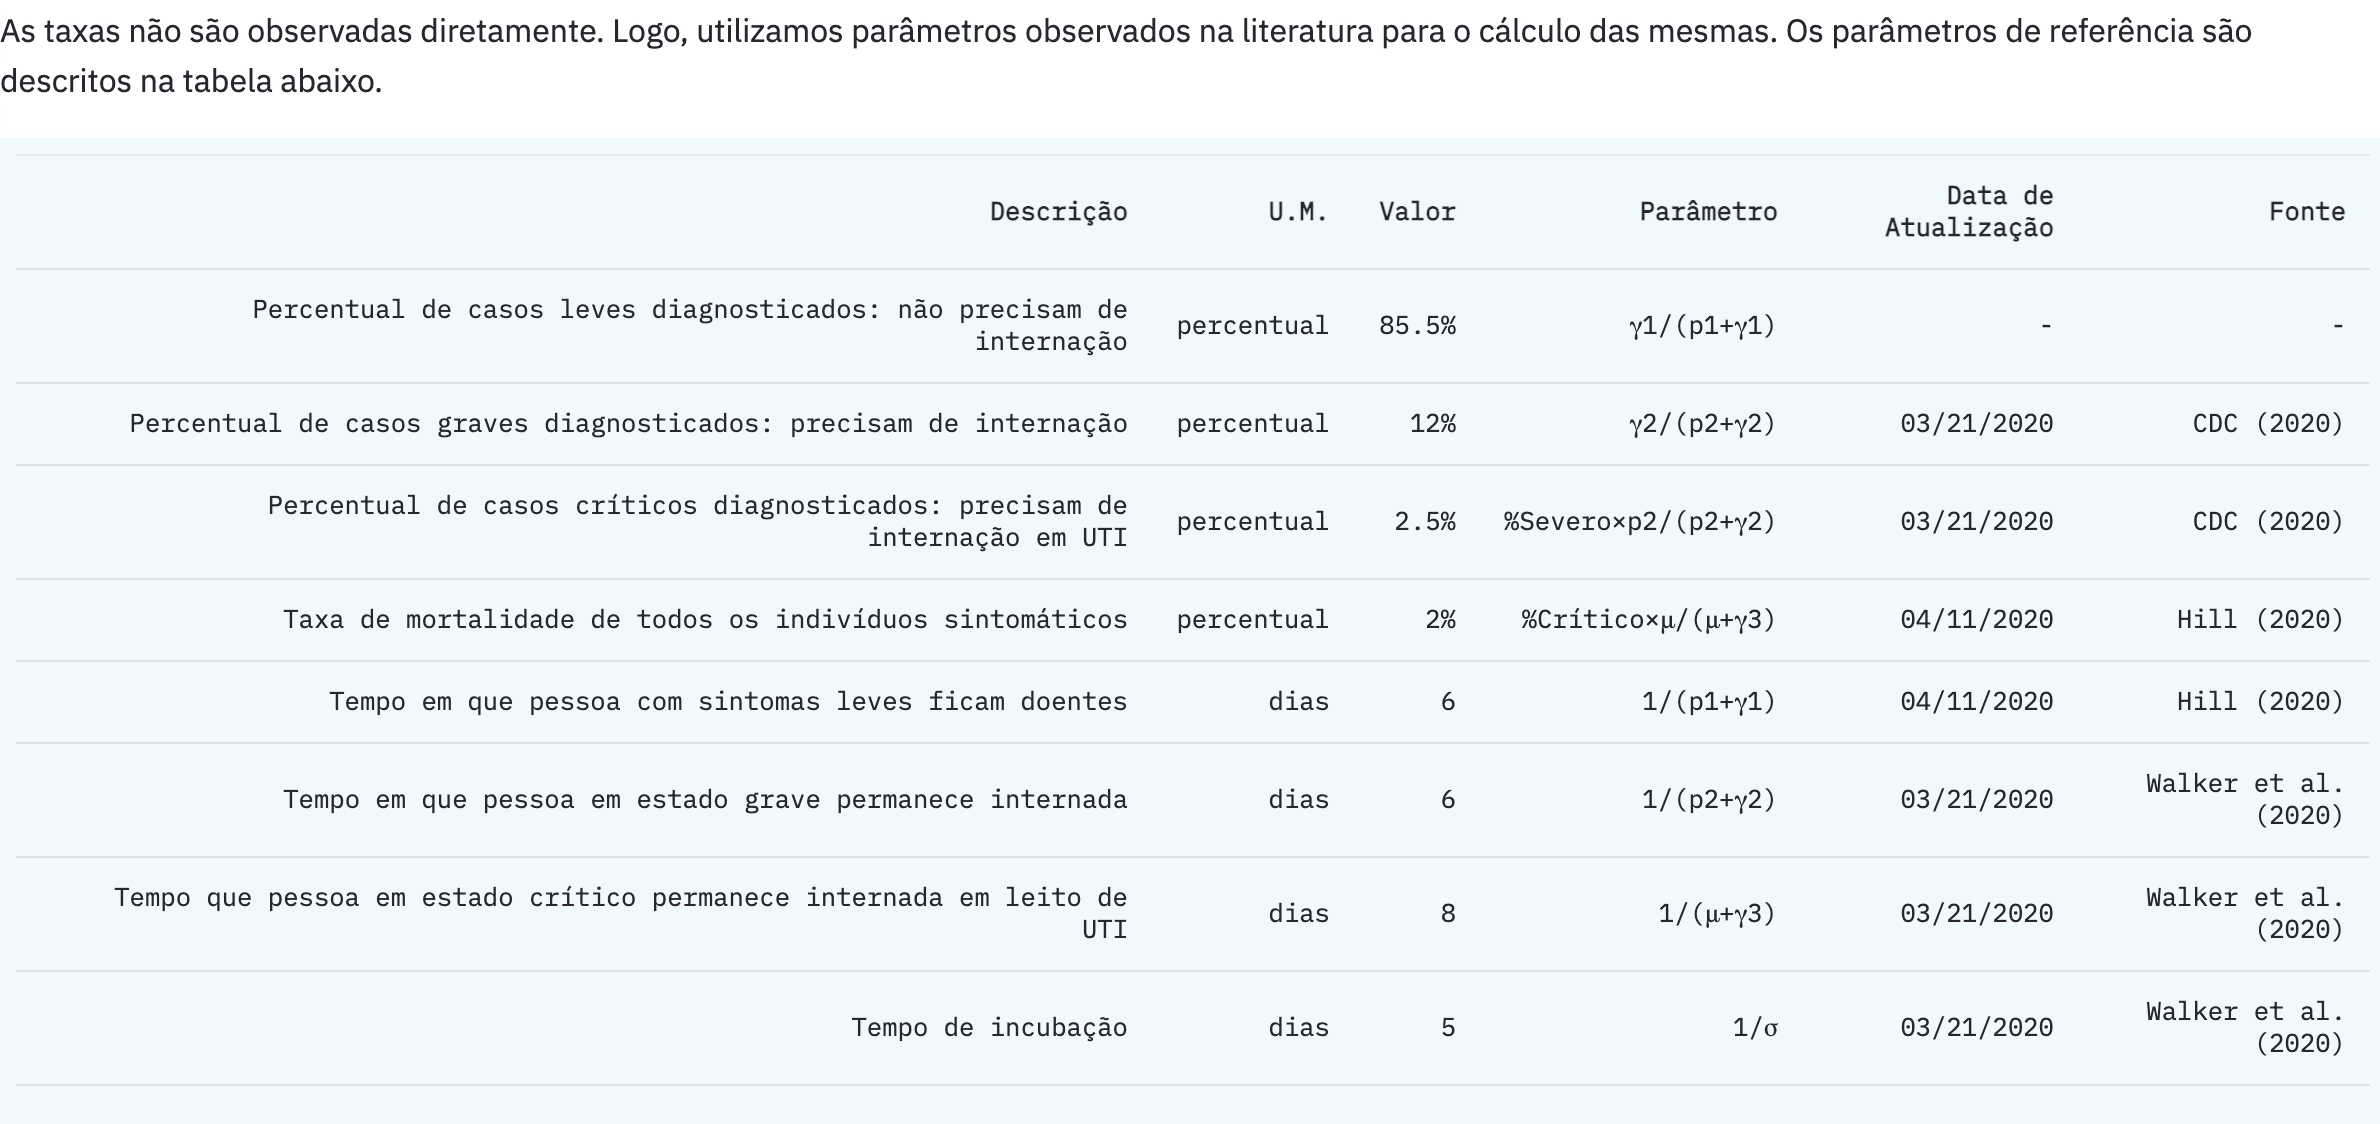

In [41]:
from IPython.display import Image
Image("images/config_values.png")

In [2]:
url = "https://raw.githubusercontent.com/ImpulsoGov/farolcovid/stable/src/configs/config.yaml"
config = yaml.load(requests.get(url).text, Loader=yaml.FullLoader)
config["br"]["seir_parameters"]

{'asymptomatic_proportion': 0.3,
 'mild_duration': 6,
 'severe_duration': 6,
 'critical_duration': 8,
 'fatality_ratio': 0.02,
 'doubling_rate': 1.15,
 'incubation_period': 5,
 'i1_percentage': 0.855,
 'i2_percentage': 0.12,
 'i3_percentage': 0.025,
 'infected_health_care_proportion': 0.05,
 'hospitalized_by_age_perc': {'from_0_to_9': 2e-05,
  'from_10_to_19': 0.0004,
  'from_20_to_29': 0.011,
  'from_30_to_39': 0.034,
  'from_40_to_49': 0.043,
  'from_50_to_59': 0.082,
  'from_60_to_69': 0.118,
  'from_70_to_79': 0.166,
  'from_80_to_older': 0.184}}

### Carrega parâmetros de hospitalização e mortalidade por estado

Passamos a utilizar parâmetros calculados por nível geográfico (neste caso estado) levando em consideração a distriuição etária da população. Abaixo segue um trecho de nossa metodologia com mais detalhes sobre esse cálculo:
> A proporção esperada de hospitalizações é dada pela estimativa de hospitalizações de cada faixa etária, de Verity, Robert, et al. (2020) num amplo estudo com base em 3.665 casos na China, ponderado pelo total da população em cada faixa etária (População residente em 2019 - CNES). Esse valor nos fornece o percentual total de hospitalizações esperadas na população (I2+I3/I). Para obter o percentual por intensidade do caso, mantivemos a razão entre severos (I2) e críticos (I3) constante: antes tínhamos 12.5% severos e 2.5% críticos do total de casos ativos (I) - ou seja, uma razão de 0.2 críticos para cada caso severo (I3/I2) -, que passa a ser de 83.3% severos (I2) e 16.7% críticos (I3) do total estimado de hospitalizados (I2+I3 / I).

In [3]:
place_id = "state_num_id"

In [4]:
place_specific_params = pd.read_csv("http://datasource.coronacidades.org/br/states/parameters").set_index(place_id)
place_specific_params

,fatality_ratio,hospitalized_by_age_perc,i1_percentage,i2_percentage,i3_percentage,data_last_refreshed
state_num_id,,,,,,
11,0.004582,0.035272,0.964728,0.029190,0.006081,2021-01-12 18:09:07
12,0.003882,0.029194,0.970806,0.024160,0.005033,2021-01-12 18:09:07
13,0.003741,0.029431,0.970569,0.024356,0.005074,2021-01-12 18:09:07
14,0.003333,0.029069,0.970931,0.024057,0.005012,2021-01-12 18:09:07
15,0.004362,0.032281,0.967719,0.026715,0.005566,2021-01-12 18:09:07
16,0.003405,0.028235,0.971765,0.023367,0.004868,2021-01-12 18:09:07
17,0.005203,0.035553,0.964447,0.029423,0.006130,2021-01-12 18:09:07
21,0.005125,0.033957,0.966043,0.028102,0.005855,2021-01-12 18:09:07
22,0.006147,0.039047,0.960953,0.032315,0.006732,2021-01-12 18:09:07


### Gera dicionário de parâmetros de entrada da simulação

Precisamos coletar os parâmetros necessários para inicialização do modelo SEIR. Além dos citados acima, vamos coletar também os valores de inicialização de cada grupo do modelo (S,E,I1,I2,I3,R,D), a população total do estado (N) e a taxa de contágio (Rt) - que assumimos constante ao longo da projeção.

#### Importa dados atualizados dos estados

Iremos utilizar a tabela já pronta do FarolCovid para puxar os dados de:
- Casos e óbitos atualizados
- Taxa de notificação e casos ativos estimados mais recentes
- Taxa de contágio (Rt) mais recente
- Número de leitos ennfermaria e UTI mais recentes do CNES

In [47]:
df_farol = pd.read_csv("http://datasource.coronacidades.org/br/states/farolcovid/main").set_index("state_num_id")
df_farol[["state_id", "last_updated_cases", "confirmed_cases", "deaths", 
          "notification_rate", "active_cases", "rt_most_likely", 
          "number_beds", "number_icu_beds", "last_updated_number_beds"]]

,state_id,last_updated_cases,confirmed_cases,deaths,notification_rate,active_cases,rt_most_likely,number_beds,number_icu_beds,last_updated_number_beds
state_num_id,,,,,,,,,,
11,RO,2021-01-11,102518.0,1926.0,0.194211,36914.0,1.05,3164,263,2020-08-01
12,AC,2021-01-11,43346.0,826.0,0.266948,10215.0,0.99,1135,54,2020-08-01
13,AM,2021-01-11,216112.0,5756.0,0.069616,145628.0,1.04,3719,285,2020-08-01
14,RR,2021-01-11,69888.0,795.0,0.431839,5817.0,0.91,1173,31,2020-08-01
15,PA,2021-01-11,303512.0,7339.0,0.272322,41429.0,0.95,10116,782,2020-08-01
16,AP,2021-01-11,71287.0,976.0,0.196551,20417.0,1.03,822,41,2020-08-01
17,TO,2021-01-10,93261.0,1274.0,0.471565,8684.0,0.95,2099,155,2020-08-01
21,MA,2021-01-11,202050.0,4568.0,0.225196,16856.0,0.88,9595,543,2020-08-01
22,PI,2021-01-11,148032.0,2915.0,0.429010,14864.0,0.97,5035,245,2020-08-01


#### Seleciona estado especificado para simulação

Usaremos o Acre como exemplo mas sinta-se a vontade para verificar outros estados - basta indicar o `state_num_id` adequado.

In [48]:
state_num_id = 12

row = df_farol.loc[state_num_id]

#### Cria dicionário de parâmetros de inserção no modelo

In [32]:
params = prepare.prepare_simulation(row, place_id, config, place_specific_params)
params

{'population_params': {'N': 881935, 'I': 7150, 'D': 826, 'R': 154399},
 'place_specific_params': {'fatality_ratio': 0.0038824347145764,
  'i1_percentage': 0.970806436574124,
  'i2_percentage': 0.0241601904214146,
  'i3_percentage': 0.0050333730044613},
 'n_beds': 567.5,
 'n_icu_beds': 27.0,
 'R0': {'best': 0.99, 'worst': 1.14}}

### Roda simulação para 90 dias

In [35]:
dfs = simulator.run_simulation(params, config)
dfs["best"]

,S,E,I1,I2,I3,R,D,N,scenario
dias,,,,,,,,,
1,714354.050484,5205.949516,6941.266022,172.745362,35.988617,154399.000000,826.000000,881935.0,projection_current_rt
2,713448.148815,5083.126325,6822.909328,177.063988,36.488533,155537.769478,829.493533,881935.0,projection_current_rt
3,712556.262845,4969.851987,6701.041422,180.180168,37.029372,156657.596649,833.037558,881935.0,projection_current_rt
4,711679.036236,4863.816920,6577.729803,182.267825,37.576285,157757.938667,836.634265,881935.0,projection_current_rt
5,710816.856235,4763.360981,6454.364490,183.481793,38.102954,158838.550637,840.282909,881935.0,projection_current_rt
...,...,...,...,...,...,...,...,...,...
87,676553.966261,866.219464,1195.699595,40.114111,11.124316,202219.147042,1048.729210,881935.0,projection_current_rt
88,676401.375036,847.450350,1169.931521,39.255135,10.888862,202416.308699,1049.790397,881935.0,projection_current_rt
89,676252.103464,829.075817,1144.699108,38.413780,10.658116,202609.220606,1050.829111,881935.0,projection_current_rt


#### Calcula número de dias até demanda (casos severos/críticos) ultrapassar oferta de leitos (enfermaria/UTI).

In [36]:
simulator.get_dday(dfs, "I2", params["n_beds"])

{'worst': -1, 'best': -1}

In [38]:
simulator.get_dday(dfs, "I3", params["n_icu_beds"])

{'worst': 1, 'best': 1}